# GNN : リンク予測
リンク予測のため
データセットに LastFM (A subset of the last.fm music website keeping track of users’ listining information from various sources,) を用いる。

https://pytorch-geometric.readthedocs.io/en/latest/modules/datasets.html#torch_geometric.datasets.LastFM

ソースコードの元（というか殆んどパクリ）：  
https://github.com/Orbifold/pyg-link-prediction

流れは以下のとおり：
1. データセットの読み込み
1. 学習・開発・テストデータへの分割
1. NeighborLoader の定義
1. モデルの定義
1. モデルのインスタンス化 & optimizer / criterion の設定
1. モデルの学習
1. 損失の可視化
1. モデルのテスト

In [25]:
'''
データセットの読み込み
'''
from torch_geometric.datasets import LastFM
dataset = LastFM(root='.')
len(dataset)

1

下記のとおり：
- ノード数 : 716847
- エッジ数 : 13954819

In [26]:
data = dataset[0]
data

Data(x=[716847, 300], edge_index=[2, 13954819], y=[716847, 100], train_mask=[716847], val_mask=[716847], test_mask=[716847])

In [27]:
data.y

tensor([[1., 1., 1.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 1., 0.,  ..., 0., 0., 0.],
        [1., 1., 1.,  ..., 0., 0., 0.],
        [1., 1., 1.,  ..., 0., 0., 0.]])

In [28]:
# クラス数 ＆ ノードの有する特徴の次元をチェック
print(data.x)
print(dataset.num_node_features)

tensor([[-0.1099,  0.6558,  0.6379,  ..., -0.9956,  0.7760, -0.4105],
        [ 0.1312,  0.7940,  0.8931,  ..., -0.5271,  0.6866, -0.7837],
        [ 0.8454,  0.6010,  0.5898,  ..., -0.3750,  0.8268, -0.4899],
        ...,
        [-0.0935,  0.8956,  0.7136,  ..., -0.7860,  0.8488, -1.1589],
        [ 0.4001,  0.6038,  0.7244,  ..., -0.7595,  1.1091, -0.7599],
        [ 0.0641,  0.7803,  0.8644,  ..., -0.7815,  1.0045, -0.5819]])
300


In [29]:
data.num_features

300

In [34]:
'''
学習・開発・テストデータへの分割
LastFM データセットには train_mask / val_mask / test_mask が付与されるが，
これを使用せず，train : val : test = 8:1:1 に分割する。
'''
import torch
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

import torch_geometric.transforms as T
transform = T.Compose([
    T.ToUndirected(merge = True),
    # T.ToDevice(device), # GPU メモリに余裕があれば有効にする
    # T.RandomLinkSplit(num_val = 0.0005, num_test = 0.0001, is_undirected = True, add_negative_train_samples = False),
    T.RandomLinkSplit(num_val = 0.1, num_test = 0.1, is_undirected = True, add_negative_train_samples = False),
])
train_data, val_data, test_data = transform(data)

エッジ数が 13954819 であったが，以下のように train / val / test のエッジ数は
次のように調整されている。 (edge_labels の値を見ればよいのかしら？)
- train : 5868667
- val   : 1467166
- test  : 1467166

In [35]:
train_data

Data(x=[716847, 300], edge_index=[2, 11737334], y=[716847, 100], train_mask=[716847], val_mask=[716847], test_mask=[716847], edge_label=[5868667], edge_label_index=[2, 5868667])

In [36]:
val_data

Data(x=[716847, 300], edge_index=[2, 11737334], y=[716847, 100], train_mask=[716847], val_mask=[716847], test_mask=[716847], edge_label=[1467166], edge_label_index=[2, 1467166])

In [37]:
test_data

Data(x=[716847, 300], edge_index=[2, 13204500], y=[716847, 100], train_mask=[716847], val_mask=[716847], test_mask=[716847], edge_label=[1467166], edge_label_index=[2, 1467166])

In [38]:
'''
NeighborLoader の定義
'''
from torch_geometric.loader import NeighborLoader

batch_size = 2048 # 1024 # 512 # 256 # 128

# define batch loaders for the three sets
train_loader = NeighborLoader(data, num_neighbors = [10] * 2, shuffle = True,
                              input_nodes = data.train_mask, batch_size = batch_size)
val_loader = NeighborLoader(data, num_neighbors = [10] * 2,
                            input_nodes = data.val_mask, batch_size = batch_size)
test_loader = NeighborLoader(data, num_neighbors = [10] * 2,
                             input_nodes = data.test_mask, batch_size = batch_size)

In [39]:
'''
モデルの定義
'''
from torch_geometric.nn import GCNConv

class Net(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def encode(self, x, edge_index):
        # chaining two convolutions with a standard relu activation

        x = self.conv1(x, edge_index).relu()
        return self.conv2(x, edge_index)

    def decode(self, z, edge_label_index):
        # cosine similarity
        ################ print(edge_label_index.is_cuda)
        return (z[edge_label_index[0]] * z[edge_label_index[1]]).sum(dim = -1)

    def decode_all(self, z):
        prob_adj = z @ z.t()
        return (prob_adj > 0).nonzero(as_tuple = False).t()

In [40]:
'''
モデルのインスタンス化 & optimizer / criterion の設定
'''
model = Net(data.num_features, 128, 64)
optimizer = torch.optim.Adam(params = model.parameters(), lr=0.001) # 0.01)
# BCELoss creates a criterion that measures the Binary Cross Entropy between the target and the output.
criterion = torch.nn.BCEWithLogitsLoss()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

Net(
  (conv1): GCNConv(300, 128)
  (conv2): GCNConv(128, 64)
)

In [42]:
'''
モデルの学習
'''
from torch_geometric.utils import negative_sampling
from tqdm import tqdm

def train():
    """
    Single epoch model training in batches.
    :return: total loss for the epoch
    """
    model.train()
    total_examples = total_loss = 0
    # for batch in tqdm(train_loader):
    for batch in tqdm(train_loader):
        optimizer.zero_grad()
        batch = batch.to(device)
        ############### print(batch.is_cuda) # True
        batch_size = batch.batch_size
        z = model.encode(batch.x, batch.edge_index)
        neg_edge_index = negative_sampling(edge_index = batch.edge_index, num_nodes = batch.num_nodes, num_neg_samples = None, method = 'sparse')
        edge_label_index = torch.cat([batch.edge_index, neg_edge_index], dim = -1, )
        edge_label = torch.cat([torch.ones(batch.edge_index.size(1)), torch.zeros(neg_edge_index.size(1))], dim = 0)
        ############### print(device) # 'cuda'
        edge_label = edge_label.to(device) # 何故か，edge_label が cuda に乗っていないため，この処理を入れる
        out = model.decode(z, edge_label_index).view(-1)
        # loss = criterion(out[:batch_size], edge_label[:batch_size])
        ############### print(out.shape) # 13872
        ############### print(edge_label.shape) # 13872
        ############### print(out.is_cuda) # True
        ############### print(edge_label.is_cuda) # False
        loss = criterion(out, edge_label)
        # standard torch mechanics here
        loss.backward()
        optimizer.step()
        total_examples += batch_size
        total_loss += float(loss) * batch_size
    return total_loss / total_examples

loss_log = []
for epoch in range(100): # 10):
    loss = train()
    print("epoch {}, loss {}".format(epoch+1, loss))
    loss_log.append(loss)

100%|█████████████████████████████████████████| 263/263 [00:50<00:00,  5.22it/s]


epoch 1, loss 1.0692274500138181


100%|█████████████████████████████████████████| 263/263 [00:49<00:00,  5.28it/s]


epoch 2, loss 0.5122634545778054


100%|█████████████████████████████████████████| 263/263 [00:50<00:00,  5.25it/s]


epoch 3, loss 0.49535029679022685


100%|█████████████████████████████████████████| 263/263 [00:50<00:00,  5.21it/s]


epoch 4, loss 0.48520368470480174


100%|█████████████████████████████████████████| 263/263 [00:50<00:00,  5.18it/s]


epoch 5, loss 0.47761527744087384


100%|█████████████████████████████████████████| 263/263 [00:50<00:00,  5.17it/s]


epoch 6, loss 0.4733567703299833


100%|█████████████████████████████████████████| 263/263 [00:51<00:00,  5.09it/s]


epoch 7, loss 0.4696950749684346


100%|█████████████████████████████████████████| 263/263 [00:50<00:00,  5.19it/s]


epoch 8, loss 0.46650317447500617


100%|█████████████████████████████████████████| 263/263 [00:49<00:00,  5.32it/s]


epoch 9, loss 0.46332636810246397


100%|█████████████████████████████████████████| 263/263 [00:49<00:00,  5.31it/s]


epoch 10, loss 0.46020203216811795


100%|█████████████████████████████████████████| 263/263 [00:49<00:00,  5.30it/s]


epoch 11, loss 0.45814374409539704


100%|█████████████████████████████████████████| 263/263 [00:49<00:00,  5.31it/s]


epoch 12, loss 0.456498465048935


100%|█████████████████████████████████████████| 263/263 [00:49<00:00,  5.32it/s]


epoch 13, loss 0.45513408003591793


100%|█████████████████████████████████████████| 263/263 [00:49<00:00,  5.30it/s]


epoch 14, loss 0.45381898678791327


100%|█████████████████████████████████████████| 263/263 [00:49<00:00,  5.30it/s]


epoch 15, loss 0.4529528658333859


100%|█████████████████████████████████████████| 263/263 [00:50<00:00,  5.24it/s]


epoch 16, loss 0.4518066420563164


100%|█████████████████████████████████████████| 263/263 [00:49<00:00,  5.30it/s]


epoch 17, loss 0.4508181098582818


100%|█████████████████████████████████████████| 263/263 [00:49<00:00,  5.29it/s]


epoch 18, loss 0.4499654588262579


100%|█████████████████████████████████████████| 263/263 [00:49<00:00,  5.32it/s]


epoch 19, loss 0.44922184144481525


100%|█████████████████████████████████████████| 263/263 [00:49<00:00,  5.30it/s]


epoch 20, loss 0.4487473153354691


100%|█████████████████████████████████████████| 263/263 [00:49<00:00,  5.31it/s]


epoch 21, loss 0.4477547958215101


100%|█████████████████████████████████████████| 263/263 [00:49<00:00,  5.30it/s]


epoch 22, loss 0.44701237869625


100%|█████████████████████████████████████████| 263/263 [00:49<00:00,  5.30it/s]


epoch 23, loss 0.4463699289457336


100%|█████████████████████████████████████████| 263/263 [00:49<00:00,  5.34it/s]


epoch 24, loss 0.4459118491360932


100%|█████████████████████████████████████████| 263/263 [00:49<00:00,  5.31it/s]


epoch 25, loss 0.4454082063100467


100%|█████████████████████████████████████████| 263/263 [00:49<00:00,  5.30it/s]


epoch 26, loss 0.444935116287718


100%|█████████████████████████████████████████| 263/263 [00:49<00:00,  5.34it/s]


epoch 27, loss 0.44445806040413255


100%|█████████████████████████████████████████| 263/263 [00:49<00:00,  5.27it/s]


epoch 28, loss 0.44434806148535627


100%|█████████████████████████████████████████| 263/263 [00:49<00:00,  5.32it/s]


epoch 29, loss 0.4444344800654747


100%|█████████████████████████████████████████| 263/263 [00:49<00:00,  5.33it/s]


epoch 30, loss 0.44356674061438206


100%|█████████████████████████████████████████| 263/263 [00:49<00:00,  5.32it/s]


epoch 31, loss 0.443387048941282


100%|█████████████████████████████████████████| 263/263 [00:49<00:00,  5.27it/s]


epoch 32, loss 0.44324218766311496


100%|█████████████████████████████████████████| 263/263 [00:52<00:00,  4.99it/s]


epoch 33, loss 0.4427833559825131


100%|█████████████████████████████████████████| 263/263 [00:53<00:00,  4.96it/s]


epoch 34, loss 0.44240170373176896


100%|█████████████████████████████████████████| 263/263 [00:51<00:00,  5.08it/s]


epoch 35, loss 0.44230987184231313


100%|█████████████████████████████████████████| 263/263 [00:54<00:00,  4.85it/s]


epoch 36, loss 0.4421024352571234


100%|█████████████████████████████████████████| 263/263 [00:49<00:00,  5.27it/s]


epoch 37, loss 0.4418267843361923


100%|█████████████████████████████████████████| 263/263 [00:49<00:00,  5.26it/s]


epoch 38, loss 0.44142977842673564


100%|█████████████████████████████████████████| 263/263 [00:50<00:00,  5.26it/s]


epoch 39, loss 0.4411218720701621


100%|█████████████████████████████████████████| 263/263 [00:50<00:00,  5.19it/s]


epoch 40, loss 0.4411797715579072


100%|█████████████████████████████████████████| 263/263 [00:50<00:00,  5.22it/s]


epoch 41, loss 0.4409390410678662


100%|█████████████████████████████████████████| 263/263 [00:50<00:00,  5.25it/s]


epoch 42, loss 0.44049132272319946


100%|█████████████████████████████████████████| 263/263 [00:50<00:00,  5.25it/s]


epoch 43, loss 0.44027957547003316


100%|█████████████████████████████████████████| 263/263 [00:50<00:00,  5.24it/s]


epoch 44, loss 0.44005860082777926


100%|█████████████████████████████████████████| 263/263 [00:49<00:00,  5.26it/s]


epoch 45, loss 0.4399586721334993


100%|█████████████████████████████████████████| 263/263 [00:49<00:00,  5.28it/s]


epoch 46, loss 0.4395165665213746


100%|█████████████████████████████████████████| 263/263 [00:49<00:00,  5.29it/s]


epoch 47, loss 0.4395892836565715


100%|█████████████████████████████████████████| 263/263 [00:50<00:00,  5.18it/s]


epoch 48, loss 0.4392805904242304


100%|█████████████████████████████████████████| 263/263 [00:51<00:00,  5.09it/s]


epoch 49, loss 0.43920717205976406


100%|█████████████████████████████████████████| 263/263 [00:51<00:00,  5.12it/s]


epoch 50, loss 0.4389995744557808


100%|█████████████████████████████████████████| 263/263 [00:50<00:00,  5.22it/s]


epoch 51, loss 0.4388341280552548


100%|█████████████████████████████████████████| 263/263 [00:49<00:00,  5.27it/s]


epoch 52, loss 0.4387252623394728


100%|█████████████████████████████████████████| 263/263 [00:51<00:00,  5.16it/s]


epoch 53, loss 0.43865013270069375


100%|█████████████████████████████████████████| 263/263 [00:50<00:00,  5.21it/s]


epoch 54, loss 0.4381250640663762


100%|█████████████████████████████████████████| 263/263 [00:50<00:00,  5.25it/s]


epoch 55, loss 0.43790189881055014


100%|█████████████████████████████████████████| 263/263 [00:50<00:00,  5.25it/s]


epoch 56, loss 0.43769195418112083


100%|█████████████████████████████████████████| 263/263 [00:49<00:00,  5.30it/s]


epoch 57, loss 0.43761392209591893


100%|█████████████████████████████████████████| 263/263 [00:49<00:00,  5.33it/s]


epoch 58, loss 0.4374933412013136


100%|█████████████████████████████████████████| 263/263 [00:49<00:00,  5.35it/s]


epoch 59, loss 0.43731805896755044


100%|█████████████████████████████████████████| 263/263 [00:49<00:00,  5.34it/s]


epoch 60, loss 0.43733897365442104


100%|█████████████████████████████████████████| 263/263 [00:49<00:00,  5.28it/s]


epoch 61, loss 0.43687461358395324


100%|█████████████████████████████████████████| 263/263 [00:49<00:00,  5.31it/s]


epoch 62, loss 0.4368278654360009


100%|█████████████████████████████████████████| 263/263 [00:49<00:00,  5.33it/s]


epoch 63, loss 0.4366771648743159


100%|█████████████████████████████████████████| 263/263 [00:50<00:00,  5.22it/s]


epoch 64, loss 0.4365752373675112


100%|█████████████████████████████████████████| 263/263 [00:49<00:00,  5.31it/s]


epoch 65, loss 0.43640941237519065


100%|█████████████████████████████████████████| 263/263 [00:50<00:00,  5.23it/s]


epoch 66, loss 0.436042018742226


100%|█████████████████████████████████████████| 263/263 [00:50<00:00,  5.25it/s]


epoch 67, loss 0.4359753619334966


100%|█████████████████████████████████████████| 263/263 [00:50<00:00,  5.26it/s]


epoch 68, loss 0.4359798726900312


100%|█████████████████████████████████████████| 263/263 [00:49<00:00,  5.27it/s]


epoch 69, loss 0.4359642949905926


100%|█████████████████████████████████████████| 263/263 [00:50<00:00,  5.25it/s]


epoch 70, loss 0.43570197145127143


100%|█████████████████████████████████████████| 263/263 [00:52<00:00,  4.98it/s]


epoch 71, loss 0.43545896110460436


100%|█████████████████████████████████████████| 263/263 [00:52<00:00,  5.03it/s]


epoch 72, loss 0.4354839327308706


100%|█████████████████████████████████████████| 263/263 [00:51<00:00,  5.15it/s]


epoch 73, loss 0.4352983234944244


100%|█████████████████████████████████████████| 263/263 [00:51<00:00,  5.07it/s]


epoch 74, loss 0.4351232596230176


100%|█████████████████████████████████████████| 263/263 [00:49<00:00,  5.26it/s]


epoch 75, loss 0.4351872560864344


100%|█████████████████████████████████████████| 263/263 [00:50<00:00,  5.17it/s]


epoch 76, loss 0.43483536895150243


100%|█████████████████████████████████████████| 263/263 [00:50<00:00,  5.26it/s]


epoch 77, loss 0.43495056389502906


100%|█████████████████████████████████████████| 263/263 [00:49<00:00,  5.27it/s]


epoch 78, loss 0.43469072232317174


100%|█████████████████████████████████████████| 263/263 [00:50<00:00,  5.26it/s]


epoch 79, loss 0.4346146397787


100%|█████████████████████████████████████████| 263/263 [00:49<00:00,  5.30it/s]


epoch 80, loss 0.43440567996454316


100%|█████████████████████████████████████████| 263/263 [00:49<00:00,  5.27it/s]


epoch 81, loss 0.4346375587078515


100%|█████████████████████████████████████████| 263/263 [00:49<00:00,  5.26it/s]


epoch 82, loss 0.4343136592638343


100%|█████████████████████████████████████████| 263/263 [00:49<00:00,  5.29it/s]


epoch 83, loss 0.434248770529301


100%|█████████████████████████████████████████| 263/263 [00:49<00:00,  5.30it/s]


epoch 84, loss 0.4340502736557409


100%|█████████████████████████████████████████| 263/263 [00:50<00:00,  5.21it/s]


epoch 85, loss 0.4340136550501787


100%|█████████████████████████████████████████| 263/263 [00:49<00:00,  5.32it/s]


epoch 86, loss 0.4338768820621082


100%|█████████████████████████████████████████| 263/263 [00:49<00:00,  5.36it/s]


epoch 87, loss 0.43388519847917534


100%|█████████████████████████████████████████| 263/263 [00:49<00:00,  5.28it/s]


epoch 88, loss 0.4337951749794092


100%|█████████████████████████████████████████| 263/263 [00:51<00:00,  5.09it/s]


epoch 89, loss 0.4337023692647915


100%|█████████████████████████████████████████| 263/263 [00:50<00:00,  5.18it/s]


epoch 90, loss 0.43346554539876747


100%|█████████████████████████████████████████| 263/263 [00:51<00:00,  5.11it/s]


epoch 91, loss 0.4333802746651831


100%|█████████████████████████████████████████| 263/263 [00:50<00:00,  5.24it/s]


epoch 92, loss 0.4334309227976427


100%|█████████████████████████████████████████| 263/263 [00:50<00:00,  5.25it/s]


epoch 93, loss 0.4330452942316721


100%|█████████████████████████████████████████| 263/263 [00:49<00:00,  5.28it/s]


epoch 94, loss 0.43305706639319436


100%|█████████████████████████████████████████| 263/263 [00:50<00:00,  5.25it/s]


epoch 95, loss 0.4331047643943512


100%|█████████████████████████████████████████| 263/263 [00:49<00:00,  5.29it/s]


epoch 96, loss 0.43296087189933874


100%|█████████████████████████████████████████| 263/263 [00:49<00:00,  5.26it/s]


epoch 97, loss 0.4330701914573151


100%|█████████████████████████████████████████| 263/263 [00:49<00:00,  5.28it/s]


epoch 98, loss 0.4328849049779666


100%|█████████████████████████████████████████| 263/263 [00:50<00:00,  5.19it/s]


epoch 99, loss 0.4326521852994119


100%|█████████████████████████████████████████| 263/263 [00:51<00:00,  5.13it/s]

epoch 100, loss 0.43254924718060284


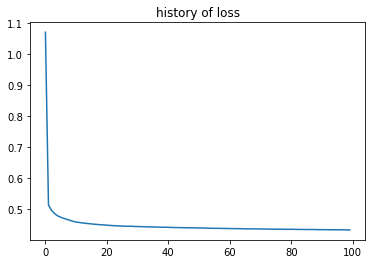

In [43]:
'''
損失の可視化
'''
import matplotlib.pyplot as plt
plt.plot(loss_log)
plt.title("history of loss")
plt.show()

In [44]:
'''
モデルのテスト
'''
from sklearn.metrics import roc_auc_score, f1_score
import numpy as np

def test(loader):
    """
    Evalutes the model on the test set.
    :param loader: the batch loader
    :return: a score
    """
    model.eval()
    scores = []
    threshold = torch.tensor([0.7]).to(device)
    for batch in tqdm(loader):
        batch = batch.to(device)
        z = model.encode(batch.x, batch.edge_index)
        out = model.decode(z, batch.edge_index).view(-1).sigmoid()
        pred = (out > threshold).float() * 1
        score = f1_score(np.ones(batch.edge_index.size(1)), pred.cpu().numpy())
        scores.append(score)
    return np.average(scores)

val_acc = test(val_loader)
print("val_acc:", val_acc)
test_acc = test(test_loader)
print("test_acc:", test_acc)

100%|███████████████████████████████████████████| 53/53 [00:05<00:00,  9.06it/s]


val_acc: 0.9871741375239059


100%|███████████████████████████████████████████| 36/36 [00:03<00:00,  9.08it/s]

test_acc: 0.9875768680880405
